In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import tensorflow_probability as tfp
import calfem.geometry as cfg
import calfem.mesh as cfm
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import sys
import os
import json

In [2]:
def PlotMesh(nodes, boundaryNodes, elements,lineWidth=1):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k',linewidth=lineWidth)
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k',linewidth=lineWidth)
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r',linewidth=lineWidth)
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    # a = np.roll(nodes[:,0],1)*np.roll(nodes[:,1],2) - np.roll(nodes[:,0],2)*np.roll(nodes[:,1],1)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    l_BC = BCfunc(alpha*2*np.pi)
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=False, max_iter=10):

    l_prev = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=None)

    err = 1
    i = 1
    while err>tol and i<max_iter:
        l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=l_prev.copy())
        err = ((l-l_prev)**2).mean()
        if show_err:
            print(f'Iteration {i}; err = {err}')
        i+=1
        l_prev = l.copy()

    return l, i

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

def PlotFEMsoluttionDict(solution):
    nodes = np.array(solution['nodes'])
    elements = np.array(solution['elements'])
    l = np.array(solution['l'])
    PlotFEMsolution(nodes, elements,l)

def GenerateGeometry(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    g.spline(list(range(p.shape[0]))+[0])
    g.surface([0])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = np.array(bdofs[0])-1
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)

    alpha = GetDistAlongBoundary(nodes,boundaryNodes)
    return nodes, elements, boundaryNodes, internalNodes, alpha

def GetRandomBCfuncAlpha(n_order=3, r=1):
    p = np.random.randn(2,n_order,r)
    BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
    alpha = np.linspace(0,2*np.pi,100)
    vals = BCfunc_unscaled(alpha)
    vals_max = np.max(vals)
    vals_min = np.min(vals)
    BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1
    return BCfunc

def SortBoundaryNodes(boundaryNodes,nodes):
    boundaryNodesSorted = [boundaryNodes[0]]
    boundaryNodesNotSorted = np.delete(boundaryNodes,0)
    for i in range(1,len(boundaryNodes)):
        idx = ((nodes[boundaryNodes[i]]-nodes[boundaryNodesNotSorted])**2).sum(axis=1).argmin()
        boundaryNodesSorted.append(boundaryNodesNotSorted[idx])
        boundaryNodesNotSorted = np.delete(boundaryNodesNotSorted,idx)
    return np.array(boundaryNodesSorted)

def GetDistAlongBoundary(nodes,boundaryNodes):
    ds = [0]+[np.sqrt(((nodes[boundaryNodes[i-1]]-nodes[boundaryNodes[i]])**2).sum()) for i in range(boundaryNodes.shape[0])]
    s = np.cumsum(ds)
    s = s[:-1]/s[-1]
    return s

def GetRandomFixedPoints(n_min = 4,n_max = 10):
    n_points = np.random.randint(n_min,n_max)
    i = 0
    while True:
        angles = np.random.lognormal(0,1,n_points)
        angles = angles/np.sum(angles)*2*np.pi
        i += 1
        if np.all(angles<np.pi) and np.all(angles>np.pi/6):
            break
    # print(i)
    angles = np.cumsum(angles)-angles[0]
    # r = np.abs(np.random.randn(n_points)+1)+0.5
    # r[r>3] = 3
    r = np.random.uniform(0.5,1.5,n_points)
    points = np.zeros((n_points,2))
    for i in range(angles.shape[0]):
        points[i,:] = r[i]*np.array([np.cos(angles[i]),np.sin(angles[i])])
    return points

def GenerateRandomSolution(n_min = 4, n_max = 10, elSize = 0.07, n_order = 3):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
    ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l,_ = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
    mesh = {'nodes':nodes,'elements':elements,'boundaryNodes':boundaryNodes,'internalNodes':internalNodes,'points':points, 'alpha':alpha}
    return l, mesh, points

In [3]:
n_min = 4
n_max = 10
elSize = 0.2
n_order = 3

points = GetRandomFixedPoints(n_min,n_max)
g = GenerateGeometry(points)
nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
A = np.concatenate([
    np.concatenate([[[1]],[[0]]],axis=1),
    np.concatenate([[[0]],[[1]]],axis=1)
    ],axis=0)
r = 1
BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
l_BC = BCfunc(alpha*2*np.pi)

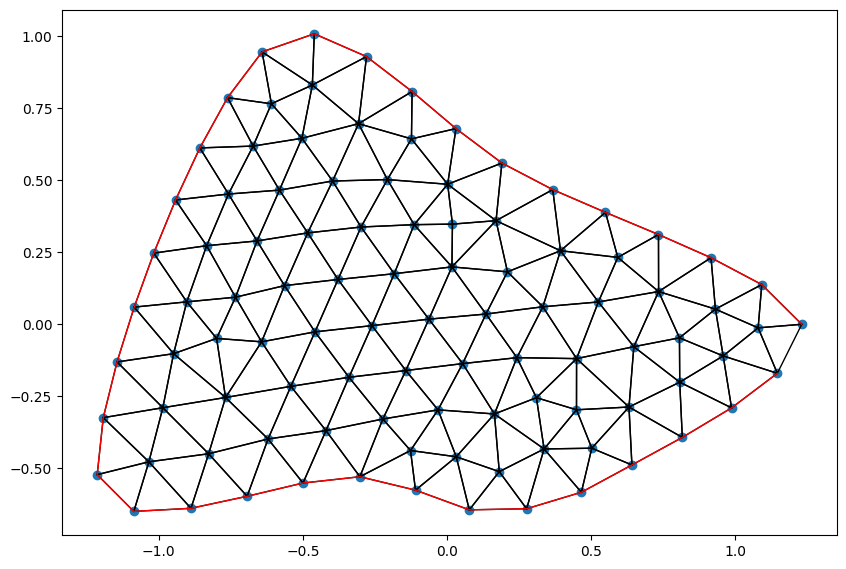

In [4]:
PlotMesh(nodes, boundaryNodes, elements,lineWidth=1)

In [5]:
def SolveFEM(nodes, elements, boundaryNodes, l_BC, source_term, internalNodes, r, A_l):
    l = np.zeros((nodes.shape[0], r))

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))
    f -= source_term

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

l_BC_zeros = np.zeros(shape=l_BC.shape)
b_term = nodes[:,:1]
l = SolveFEM(nodes, elements, boundaryNodes, l_BC_zeros, b_term, internalNodes, r, A)

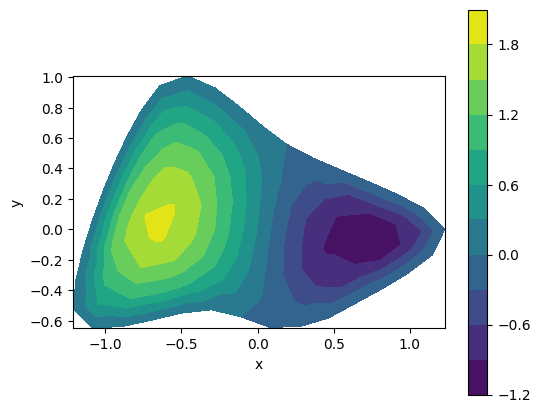

In [6]:
PlotFEMsolution(nodes, elements,l)

In [7]:
def GetK_tf(nodes_el, A, r):
    # Get the stiffness matrix for a triangular elements, function is vectorized so that a batch of elements can be processed at once
    #   nodes_el - [N,3,2] tensor which containes the x,y positions of the 3 nodes of N triangles
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables

    # calculate the triangle area and the B matrix which is a derivative of the shape functions (B = div(N))
    b = (tf.roll(nodes_el[:,:,1],1,axis=1) - tf.roll(nodes_el[:,:,1],2,axis=1))
    b = tf.reshape(b,(-1,3,1))
    c = (tf.roll(nodes_el[:,:,0],2,axis=1) - tf.roll(nodes_el[:,:,0],1,axis=1))
    c = tf.reshape(c,(-1,3,1))
    Area = tf.abs(tf.matmul(tf.reshape(nodes_el[:,:,0],(-1,1,3)),b))/2
    I = tf.reshape(tf.eye(r),(1,r,r))
    B = tf.concat([
        tf.concat([b[:,0:1]*I, b[:,1:2]*I, b[:,2:3]*I],-1),
        tf.concat([c[:,0:1]*I, c[:,1:2]*I, c[:,2:3]*I],-1)
    ],-2)/(2*Area)
    B_T = tf.transpose(B,(0,2,1))
    return tf.matmul(tf.matmul(B_T,A),B)*Area # calculates the stiffness matrix

def SolveFEM_tf(nodes, elements, boundaryNodes, l_BC, source_term, internalNodes, r, A_l):
    """
    Solve a 2D linear FEM problem using only TensorFlow operations.
    
    Args:
        nodes: TensorFlow tensor containing node coordinates
        elements: List of element node indices
        boundaryNodes: Indices of boundary nodes
        BCfunc: Function to compute boundary conditions
        alpha: Scalar parameter for boundary conditions
        internalNodes: Indices of internal nodes
        r: Number of degrees of freedom per node
        A_l: Linear operator coefficient (optional)
        A: Nonlinear operator function (optional)
    
    Returns:
        TensorFlow tensor with solution at all nodes
    """
    # Convert inputs to TensorFlow tensors if they aren't already
    if not isinstance(nodes, tf.Tensor):
        nodes = tf.convert_to_tensor(nodes, dtype=tf.float32)
    if not isinstance(elements, tf.Tensor):
        elements = tf.convert_to_tensor(elements, dtype=tf.int32)
    if not isinstance(boundaryNodes, tf.Tensor):
        boundaryNodes = tf.convert_to_tensor(boundaryNodes, dtype=tf.int32)
    if not isinstance(internalNodes, tf.Tensor):
        internalNodes = tf.convert_to_tensor(internalNodes, dtype=tf.int32)
    if not isinstance(l_BC, tf.Tensor):
        l_BC = tf.convert_to_tensor(l_BC, dtype=tf.float32)
    if not isinstance(source_term, tf.Tensor):
        source_term = tf.convert_to_tensor(source_term, dtype=tf.float32)
    
    # Initialize solution vector
    total_nodes = tf.shape(nodes)[0]
    l = tf.zeros((total_nodes, r), dtype=tf.float32)
    
    # Initialize global stiffness matrix
    total_dofs = total_nodes * r
    K = tf.zeros((total_dofs, total_dofs), dtype=tf.float32)
    
    # Assemble the global stiffness matrix
    for el in tf.unstack(elements):
        # Create element DOF indices
        el_indices = tf.reshape(
            tf.stack([r * k + tf.range(r, dtype=tf.int32) for k in tf.unstack(el)]), [-1]
        )
        
        # Gather element nodes
        nodes_el = tf.gather(nodes, el)
        # Create mesh grid of indices
        el_size = tf.shape(el_indices)[0]
        idx_range = tf.range(el_size, dtype=tf.int32)
        X_idx, Y_idx = tf.meshgrid(idx_range, idx_range)
        
        
        # Get element stiffness matrix
        nodes_el = tf.reshape(nodes_el, [1, 3, 2])
        K_el = GetK_tf(nodes_el, A_l, r)[0]
        
        # Update global stiffness matrix using scatter_nd_add
        indices = tf.stack([
            tf.gather(el_indices, tf.reshape(Y_idx, [-1])),
            tf.gather(el_indices, tf.reshape(X_idx, [-1]))
        ], axis=1)
        
        K_el_flat = tf.reshape(K_el, [-1])
        K = tf.tensor_scatter_nd_add(K, indices, K_el_flat)
    
    
    # Create boundary and internal DOF indices
    bc_indices = tf.reshape(
        tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(boundaryNodes)]), [-1]
    )
    internal_indices = tf.reshape(
        tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(internalNodes)]), [-1]
    )
    
    # Compute right-hand side vector
    l_BC_flat = tf.reshape(l_BC, [-1, 1])

    f = -tf.matmul(tf.gather(K, bc_indices, axis=1), l_BC_flat)
    f -= source_term

    
    # Extract the submatrix of K corresponding to internal DOFs
    K_BC = tf.gather(tf.gather(K, internal_indices), internal_indices, axis=1)
    f = tf.gather(f, internal_indices)
    
    # Solve the system using TensorFlow's matrix_solve
    l_internal = tf.linalg.solve(K_BC, f)
    
    # Reshape the solution
    n_CDOF = tf.shape(l_internal)[0] // r
    l_internal = tf.reshape(l_internal, (n_CDOF, r))
    
    # Update the solution vector
    # Using tensor_scatter_nd_update to assign values
    l = tf.tensor_scatter_nd_update(
        l, 
        tf.expand_dims(internalNodes, axis=1),
        l_internal
    )
    
    l = tf.tensor_scatter_nd_update(
        l, 
        tf.expand_dims(boundaryNodes, axis=1),
        tf.reshape(l_BC, (-1, r))
    )
    
    return l

l_tf = SolveFEM_tf(nodes, elements, boundaryNodes, l_BC_zeros, b_term, internalNodes, r, A)

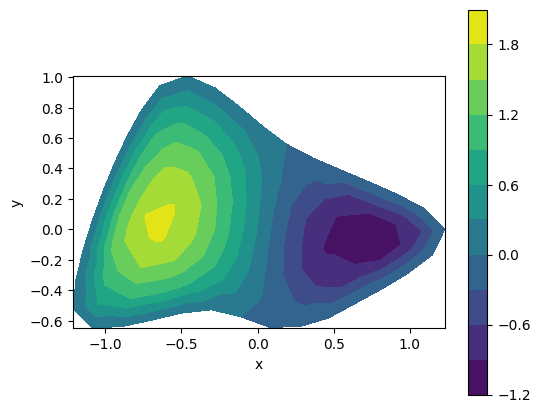

In [8]:
PlotFEMsolution(nodes, elements,l_tf.numpy())

Epoch 1/100, Loss: 0.07173, A_l:
[[ 1.5460758  -0.73205227]
 [-0.73205227  0.73338145]]
P_A:
[-0.2788922  -0.39376283  0.50817573]
A_l_grad:
[-0.00493267 -0.00189381  0.00335028]
P_m:
[-0.09999725]
Epoch 11/100, Loss: 0.0014, A_l:
[[ 0.9755623  -0.16659309]
 [-0.16659309  0.9941789 ]]
P_A:
[ 0.14495446 -0.1616902   0.18254589]
A_l_grad:
[-0.0006672  -0.00164527  0.00051441]
P_m:
[-0.31180418]
Epoch 21/100, Loss: 0.003742, A_l:
[[ 0.75508046 -0.19013396]
 [-0.19013396  1.1114326 ]]
P_A:
[ 0.33826348 -0.16449077  0.08369239]
A_l_grad:
[ 0.00187182 -0.00187832 -0.00223251]
P_m:
[-0.38376188]
Epoch 31/100, Loss: 0.0002175, A_l:
[[1.0705254  0.06905565]
 [0.06905565 0.9630538 ]]
P_A:
[0.22388205 0.07918717 0.32141384]
A_l_grad:
[-0.00023569  0.00017194  0.00022465]
P_m:
[-0.32898712]
Epoch 41/100, Loss: 0.0004278, A_l:
[[1.0816463  0.07604551]
 [0.07604551 0.98539495]]
P_A:
[0.27654815 0.0623892  0.33041057]
A_l_grad:
[-0.0002715  -0.00054551  0.00028902]
P_m:
[-0.31659994]
Epoch 51/100, Lo

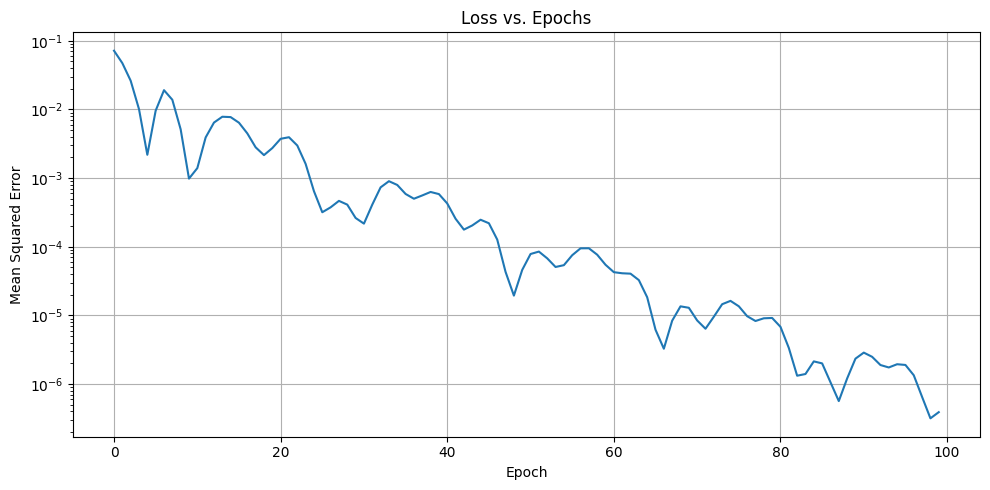

In [13]:
# def GetA(P_A,P_m):
#     A = tf.matmul(P_A,P_A,transpose_a=True)
#     # A = P + tf.transpose(P,perm=[1,0])
#     # Normalize the matrix
#     A = tf.math.exp(P_m) * A / tf.sqrt(tf.reduce_mean(tf.square(A)))
#     return A

tfb = tfp.bijectors
fill_tril = tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1e-5)  # ε-shift avoids zeros

def GetA(P_A,P_m):
    L = fill_tril(P_A) 
    A = tf.matmul(L, L, transpose_b=True)
    A = tf.math.exp(P_m) * A / tf.sqrt(tf.reduce_mean(tf.square(A)))
    return A

def optimize_A_l(nodes_np, elements_np, boundaryNodes_np, l_BC_np, source_term_np, internalNodes_np, 
                r, l_label_np, P_A, P_m, learning_rate=0.001, epochs=1000, batch_size=None):
    """
    Optimize the A_l parameter in SolveFEM_tf to match target solutions.
    
    Args:
        nodes_np: NumPy array of node coordinates
        elements_np: NumPy array of element node indices
        boundaryNodes_np: NumPy array of boundary node indices
        l_BC_np: NumPy array of boundary conditions
        source_term_np: NumPy array of source term
        internalNodes_np: NumPy array of internal node indices
        r: Number of degrees of freedom per node
        l_label_np: NumPy array of target solutions
        learning_rate: Learning rate for optimizer
        epochs: Number of training epochs
        batch_size: Batch size for training (None for full dataset)
        
    Returns:
        Optimized A_l matrix and training history
    """

    # A_l_init = GetA(P_A).numpy()
    # print(f"Initial A_l:\n{A_l_init}")
    # l_pred = SolveFEM(nodes_np, elements_np, boundaryNodes_np, l_BC_np, source_term_np, internalNodes_np, r, A_l_init)
    # print(f"Initial loss: {np.mean(np.square(l_pred - l_label_np))}")

    # Convert NumPy arrays to TensorFlow constants
    nodes = tf.constant(nodes_np, dtype=tf.float32)
    elements = tf.constant(elements_np, dtype=tf.int32)
    boundaryNodes = tf.constant(boundaryNodes_np, dtype=tf.int32)
    l_BC = tf.constant(l_BC_np, dtype=tf.float32)
    internalNodes = tf.constant(internalNodes_np, dtype=tf.int32)
    l_label = tf.constant(l_label_np, dtype=tf.float32)
    source_term = tf.constant(source_term_np, dtype=tf.float32)
    
    
    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Lists to store metrics for visualization
    loss_history = []
    
    # Training loop
    for epoch in range(epochs):
        # Perform one optimization step
        with tf.GradientTape() as tape:
            # Get the A_l matrix
            A_l = GetA(P_A, P_m)
            # Forward pass through the FEM solver
            l_pred = SolveFEM_tf(nodes, elements, boundaryNodes, l_BC,
                                source_term, internalNodes, r, A_l)

            # Mean squared error between predicted and target solutions
            loss = tf.reduce_mean(tf.square(l_pred - l_label))

        # Compute gradients for both P_A and P_m simultaneously
        trainable_vars = [P_A, P_m]
        gradients = tape.gradient(loss, trainable_vars)

        # Apply gradients to update both variables
        optimizer.apply_gradients(zip(gradients, trainable_vars))

        
        # Store loss for visualization
        loss_value = loss.numpy()
        loss_history.append(loss_value)
        
        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            A_l_np = A_l.numpy()
            P_A_np = P_A.numpy()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value:.4g}, A_l:\n{A_l_np}")
            print(f"\033[32mP_A:\n{P_A_np}\033[0m")
            print(f"\033[31mA_l_grad:\n{gradients[0].numpy()*optimizer.learning_rate}\033[0m")
            print(f"\033[30mP_m:\n{P_m.numpy()}\033[0m")
    
    # Final prediction
    A_l_final = GetA(P_A,P_m)
    l_pred_final = SolveFEM_tf(nodes, elements, boundaryNodes, l_BC, 
                              source_term, internalNodes, r, A_l_final)
    final_loss = tf.reduce_mean(tf.square(l_pred_final - l_label)).numpy()
    print(f"Final loss: {final_loss:.6f}")
    print(f"Optimized A_l:\n{A_l_final.numpy()}")
    
    # Visualize training progress
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.yscale('log')  # Log scale often helps visualize convergence better
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return A_l_final.numpy(), loss_history

# tf.random.set_seed(1)
# P_A = tf.random_normal_initializer(mean=0.0, stddev=0.5)(shape=[2, 2])
# # P_A = np.eye(2)
# P_A = tf.Variable(P_A, dtype=tf.float32, name="P_A")

P_A = tf.Variable(tf.random.normal([2*r * (2*r + 1) // 2]))

P_m = tf.Variable([0.0], dtype=tf.float32, name="P_m")
A_opt,lss_history = optimize_A_l(nodes, elements, boundaryNodes, l_BC_np=l_BC_zeros, source_term_np=b_term, internalNodes_np=internalNodes, 
                r=r, l_label_np=l, P_A=P_A, P_m=P_m, learning_rate=0.1, epochs=100, batch_size=None)

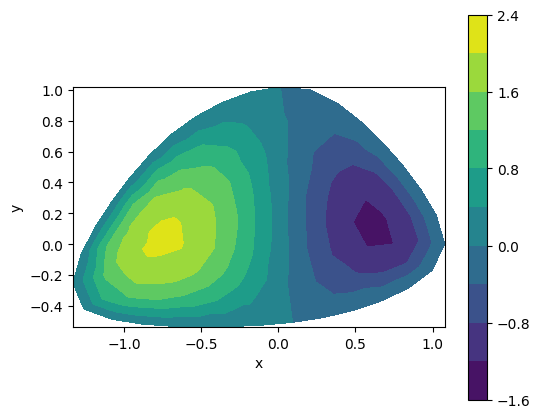

In [65]:
PlotFEMsolution(nodes, elements,l)

In [43]:
A_opt

array([[-1.345937 ,  0.1664221],
       [ 0.1664221, -1.2514987]], dtype=float32)